In [2]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import folium
import geopandas
import pandas as pd
import sqlite3
import shapely.wkb
from sklearn.preprocessing import MinMaxScaler, StandardScaler
geopandas.options.io_engine = "pyogrio"

conn = sqlite3.connect('db.sqlite3')
cursor = conn.cursor()

In [7]:
data = conn.execute("""
with attendances_month as (
select
    sum(data.value) as value,
    data.commune_id as commune_id,
    data.report_id as report_id,
    data.year || '-' || (
        case data.cohort
            when 'Enero' then '01'
            when 'Febrero' then '02'
            when 'Marzo' then '03'
            when 'Abril' then '04'
            when 'Mayo' then '05'
            when 'Junio' then '06'
            when 'Julio' then '07'
            when 'Agosto' then '08'
            when 'Septiembre' then '09'
            when 'Octubre' then '10'
            when 'Noviembre' then '11'
            when 'Diciembre' then '12'
        end
    ) || '-01' as date
from data
where cohort in ('Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre')
  and data.year > 2020
group by date, commune_id, report_id
),
aqi_month as (
select
    commune_id,
    date(datetime, 'unixepoch', 'start of month') as date, -- collapse entire month to first day of month
    avg(case when contaminant = 'CO' then concentration end)     as CO,
    avg(case when contaminant = 'MP10' then concentration end)   as MP10,
    avg(case when contaminant = 'MP2.5' then concentration end)  as MP25,
    avg(case when contaminant = 'NO' then concentration end)     as NO,
    avg(case when contaminant = 'NO2' then concentration end)    as NO2,
    avg(case when contaminant = 'NOx' then concentration end)    as NOx,
    avg(case when contaminant = 'O3' then concentration end)     as O3,
    avg(case when contaminant = 'SO2' then concentration end)    as SO2
from contaminant
group by date, commune_id
)
select 
    attendances_month.date as date,
    attendances_month.value as value,
    aqi_month.CO as CO,
    aqi_month.MP10 as MP10,
    aqi_month.MP25 as MP25,
    aqi_month.NO as NO,
    aqi_month.NO2 as NO2,
    aqi_month.NOx as NOx,
    aqi_month.O3 as O3,
    aqi_month.SO2 as SO2
from attendances_month
join aqi_month on aqi_month.date = attendances_month.date and aqi_month.commune_id = attendances_month.commune_id
join commune on commune.id = attendances_month.commune_id
join report on report.id = attendances_month.report_id
where commune.name = 'PENALOLEN'
  and report.description = 'Ingresos Programa de Salud Mental por mes y año'
""").fetchall()
# and attendances_month.date not in ('2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01') -- remove 2020 because of covid

data = pd.DataFrame(data, columns=['date', 'Ingresos Programa de Salud Mental por mes y año', 'CO', 'MP10', 'MP25', 'NO', 'NO2', 'NOx', 'O3', 'SO2'])

data


,date,Ingresos Programa de Salud Mental por mes y año,CO,MP10,MP25,NO,NO2,NOx,O3,SO2
0,2021-01-01,465,0.832667,79.310345,22.448276,29.721776,26.376333,51.739570,51.225806,1.008000
1,2021-02-01,325,0.997600,80.000000,24.428571,38.649754,28.133214,61.331768,53.846154,1.097857
2,2021-03-01,642,1.034194,91.800000,27.333333,54.666316,33.130645,79.825768,48.533333,1.157742
3,2021-04-01,544,1.472308,125.076923,40.965517,62.850804,39.121333,94.161456,48.851852,1.032667
4,2021-05-01,475,2.684194,178.428571,69.965517,131.194282,59.239000,182.735632,31.482759,1.438710
5,2021-06-01,463,2.827667,182.827586,73.275862,160.385004,56.755667,206.577234,19.222222,1.181250
6,2021-07-01,420,3.243226,218.555556,91.533333,190.736299,71.847097,247.080642,21.275862,3.576667
7,2021-08-01,487,2.203103,158.607143,67.000000,131.376665,59.925334,177.731450,31.800000,2.507667
8,2021-09-01,558,1.712500,102.478261,36.928571,88.045080,43.430769,122.219488,52.100000,2.367586
9,2021-10-01,620,1.195862,89.892857,29.071429,53.248066,35.908966,84.308694,57.807692,2.748276


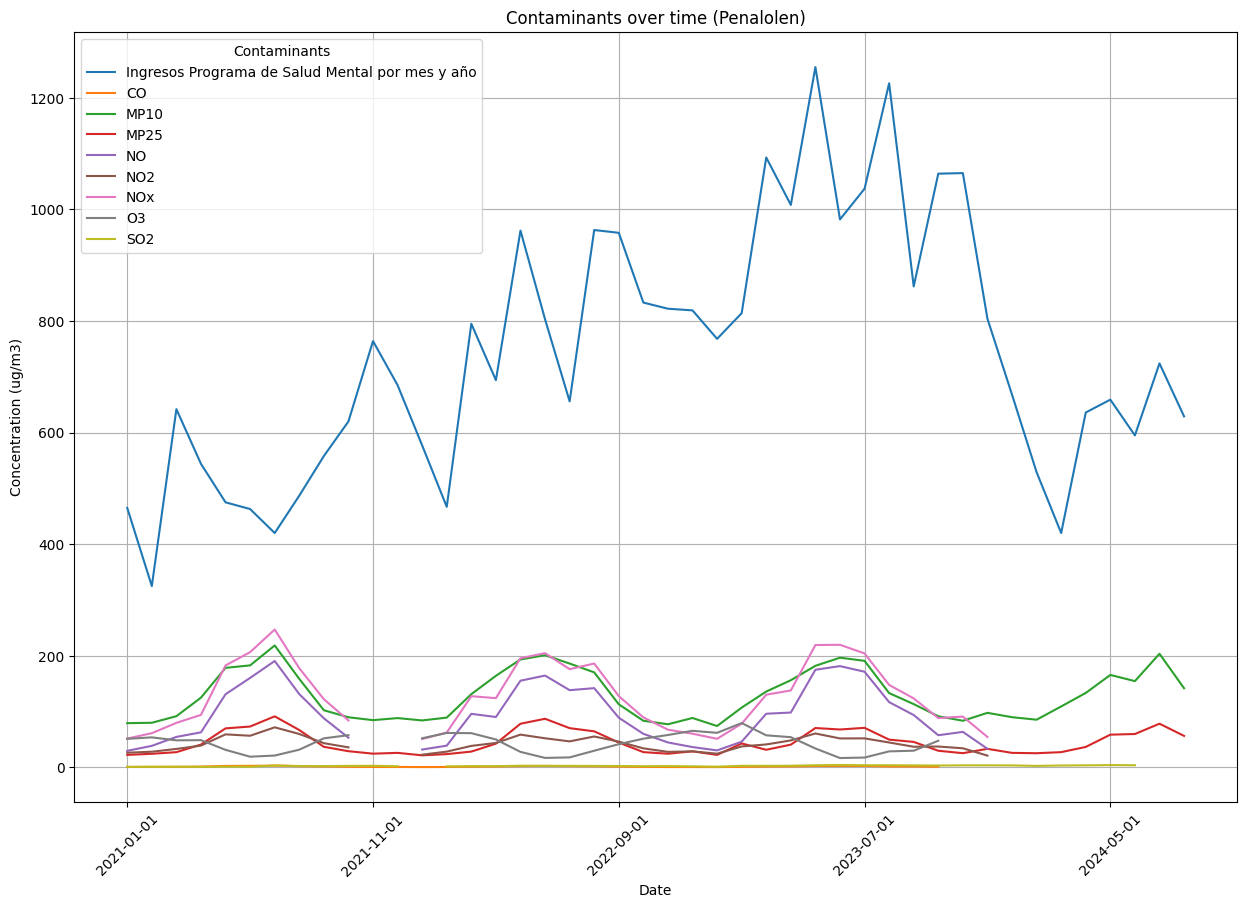

In [8]:
# graph contaminants
data.plot(x='date', y=['Ingresos Programa de Salud Mental por mes y año', 'CO', 'MP10', 'MP25', 'NO', 'NO2', 'NOx', 'O3', 'SO2'], figsize=(15, 10))
plt.xticks(rotation=45)
plt.title('Contaminants over time (Penalolen)')
plt.xlabel('Date')
plt.ylabel('Concentration (ug/m3)')
plt.legend(title='Contaminants')
plt.grid()
plt.show()

In [9]:
# check correlation
data.drop(columns=['date']).corr()

,Ingresos Programa de Salud Mental por mes y año,CO,MP10,MP25,NO,NO2,NOx,O3,SO2
Ingresos Programa de Salud Mental por mes y año,1.000000,0.099802,0.134625,0.097150,0.224877,0.114637,0.196553,-0.113904,0.496045
CO,0.099802,1.000000,0.951278,0.951353,0.967700,0.940003,0.975966,-0.850608,0.393095
MP10,0.134625,0.951278,1.000000,0.945528,0.950181,0.900184,0.952893,-0.791382,0.333343
MP25,0.097150,0.951353,0.945528,1.000000,0.932016,0.904077,0.938675,-0.846682,0.305509
NO,0.224877,0.967700,0.950181,0.932016,1.000000,0.926059,0.996521,-0.859358,0.460492
NO2,0.114637,0.940003,0.900184,0.904077,0.926059,1.000000,0.951330,-0.728465,0.328962
NOx,0.196553,0.975966,0.952893,0.938675,0.996521,0.951330,1.000000,-0.842813,0.435507
O3,-0.113904,-0.850608,-0.791382,-0.846682,-0.859358,-0.728465,-0.842813,1.000000,-0.421366
SO2,0.496045,0.393095,0.333343,0.305509,0.460492,0.328962,0.435507,-0.421366,1.000000


In [11]:
# scale
data_scaled = data.drop(columns=['date'])
columns = data_scaled.columns

# scaler = MinMaxScaler()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_scaled)

data_scaled = pd.DataFrame(data_scaled, columns=columns)
data_scaled['date'] = data['date']
data


,date,Ingresos Programa de Salud Mental por mes y año,CO,MP10,MP25,NO,NO2,NOx,O3,SO2
0,2021-01-01,465,0.832667,79.310345,22.448276,29.721776,26.376333,51.739570,51.225806,1.008000
1,2021-02-01,325,0.997600,80.000000,24.428571,38.649754,28.133214,61.331768,53.846154,1.097857
2,2021-03-01,642,1.034194,91.800000,27.333333,54.666316,33.130645,79.825768,48.533333,1.157742
3,2021-04-01,544,1.472308,125.076923,40.965517,62.850804,39.121333,94.161456,48.851852,1.032667
4,2021-05-01,475,2.684194,178.428571,69.965517,131.194282,59.239000,182.735632,31.482759,1.438710
5,2021-06-01,463,2.827667,182.827586,73.275862,160.385004,56.755667,206.577234,19.222222,1.181250
6,2021-07-01,420,3.243226,218.555556,91.533333,190.736299,71.847097,247.080642,21.275862,3.576667
7,2021-08-01,487,2.203103,158.607143,67.000000,131.376665,59.925334,177.731450,31.800000,2.507667
8,2021-09-01,558,1.712500,102.478261,36.928571,88.045080,43.430769,122.219488,52.100000,2.367586
9,2021-10-01,620,1.195862,89.892857,29.071429,53.248066,35.908966,84.308694,57.807692,2.748276


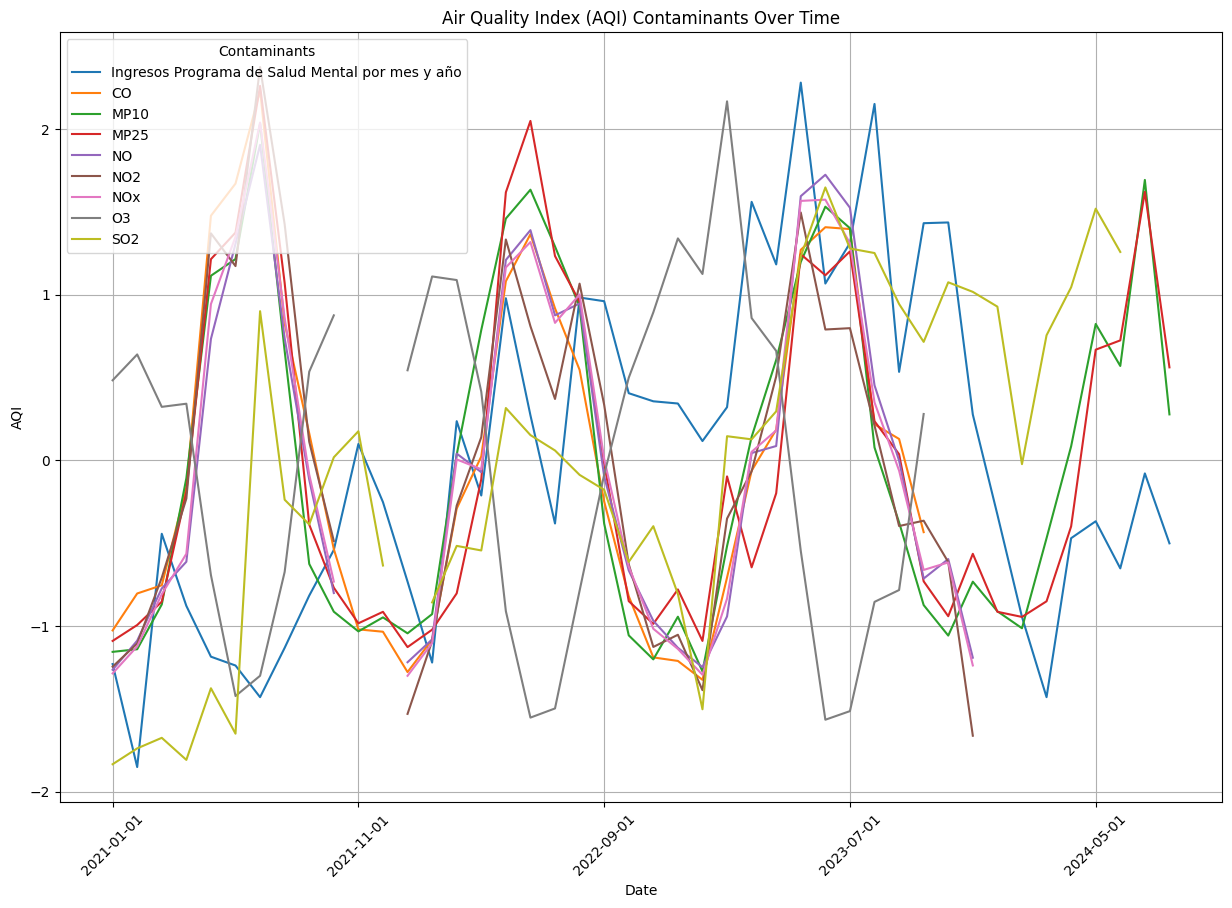

In [12]:
# graph contaminants
data_scaled.plot(x='date', y=['Ingresos Programa de Salud Mental por mes y año', 'CO', 'MP10', 'MP25', 'NO', 'NO2', 'NOx', 'O3', 'SO2'], figsize=(15, 10))
plt.xticks(rotation=45)
plt.title('Air Quality Index (AQI) Contaminants Over Time')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend(title='Contaminants')
plt.grid()
plt.show()

In [13]:
# check correlation
data_scaled.drop(columns=['date']).corr()

,Ingresos Programa de Salud Mental por mes y año,CO,MP10,MP25,NO,NO2,NOx,O3,SO2
Ingresos Programa de Salud Mental por mes y año,1.000000,0.099802,0.134625,0.097150,0.224877,0.114637,0.196553,-0.113904,0.496045
CO,0.099802,1.000000,0.951278,0.951353,0.967700,0.940003,0.975966,-0.850608,0.393095
MP10,0.134625,0.951278,1.000000,0.945528,0.950181,0.900184,0.952893,-0.791382,0.333343
MP25,0.097150,0.951353,0.945528,1.000000,0.932016,0.904077,0.938675,-0.846682,0.305509
NO,0.224877,0.967700,0.950181,0.932016,1.000000,0.926059,0.996521,-0.859358,0.460492
NO2,0.114637,0.940003,0.900184,0.904077,0.926059,1.000000,0.951330,-0.728465,0.328962
NOx,0.196553,0.975966,0.952893,0.938675,0.996521,0.951330,1.000000,-0.842813,0.435507
O3,-0.113904,-0.850608,-0.791382,-0.846682,-0.859358,-0.728465,-0.842813,1.000000,-0.421366
SO2,0.496045,0.393095,0.333343,0.305509,0.460492,0.328962,0.435507,-0.421366,1.000000


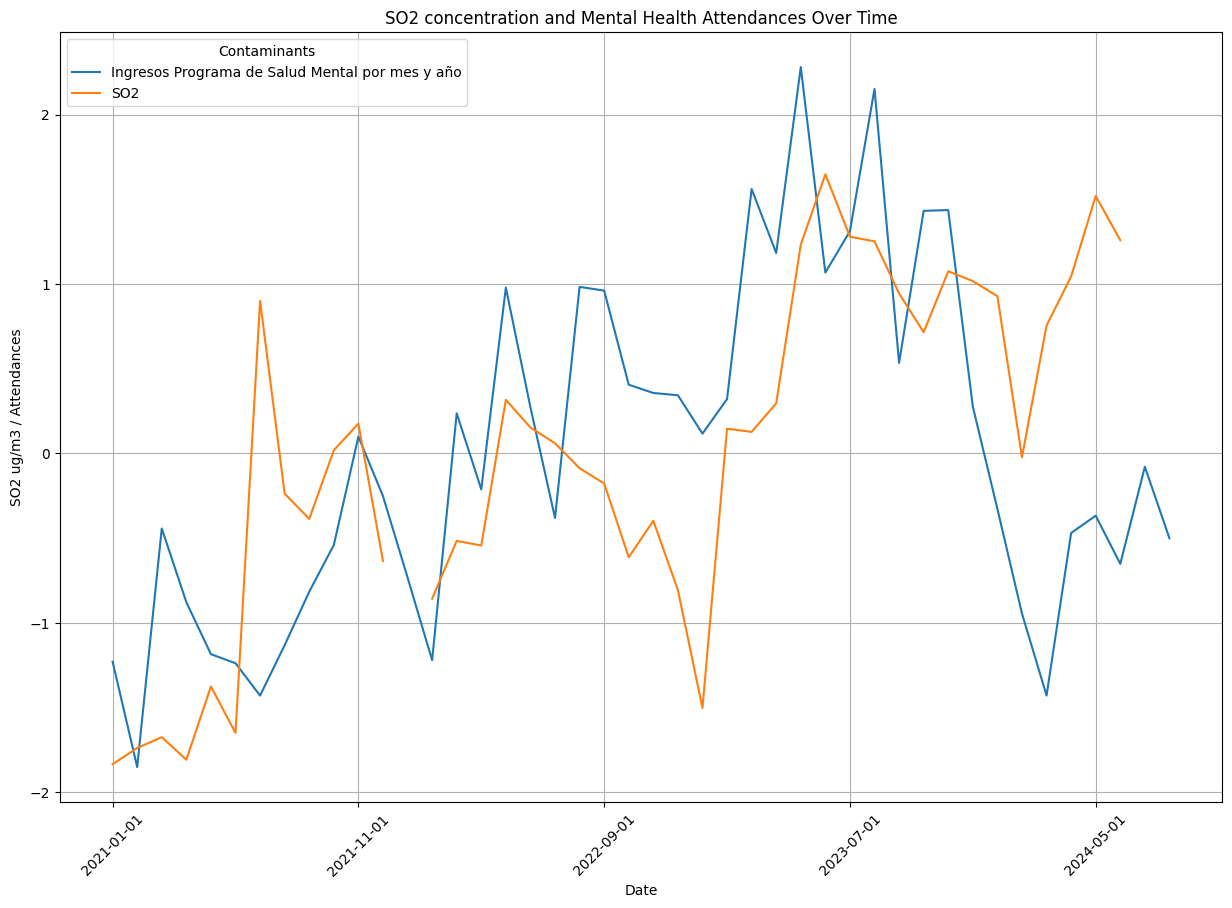

In [14]:
# graph just SO2 and mental health attendances
data_scaled.plot(x='date', y=['Ingresos Programa de Salud Mental por mes y año', 'SO2'], figsize=(15, 10))
plt.xticks(rotation=45)
plt.title('SO2 concentration and Mental Health Attendances Over Time')
plt.xlabel('Date')
plt.ylabel('SO2 ug/m3 / Attendances')
plt.legend(title='Contaminants')
plt.grid()
plt.show()